# Single Shot Detection

By Karl Heyer

In this project we build a single shot detector to classify and localize objects in an image using a subset of the data from Google's [Object Detection Kaggle Competition](https://www.kaggle.com/c/google-ai-open-images-object-detection-track). As much as I'd like to use the entire data set, I don't have the computing resources to churn through 500 GB of images in a reasonable amount of time. So instead we'll just have some fun with object detection

## Acknowledgements

Model structure and training was adapted from [fast.ai lesson 9](https://github.com/fastai/fastai/blob/master/courses/dl2/pascal-multi.ipynb)

## Contents

1. Model Architecture
2. Data Setup
3. Prepare Bounding Boxes
4. Create Dataloader
5. Create Anchor Boxes
6. Convolutional Output Functions
7. Loss Function
8. Focal Loss
9. Model Training
10. Viewing Predictions
11. Non-Maximum Suppression
12. Afterthoughts

# 1. Model Architecture

For this project we will use a single shot detection model to localize and classify objects in an image. On a high level, this is what the model looks like:[](attachment:ssd_arch.png)

<img src="ssd_arch.png">

(Note: the image shows the SSD model built on top of a VGG model. We will use a resnet model)

Basically the model uses the outputs of several convolutional layers (tensors) to classify and localize objects in the receptive field of the convolutional output. This takes a few paragraphs to properly explain. 

## Receptive Field

The concept of the receptive field refers to how an activation in a given convolutional layer relates to the original image. For example when the image has been convolved down to a size of $2x2$, the receptive field of each value in the $2x2$ matrix corresponds to a quadrant of the original image.[](attachment:receptive.jpg)

<img src="receptive.jpg">

We will design the model to output a tensor where the x and y dimensions correspond to the receptive field, and the z dimension corresponds to predictions for a single object in that receptive field. So if there are c classes to predict on, the output will be a prediction of $4+c$ values - 4 bounding box coordinates and c predictions for each class. For a $2x2$ receptive field, the output will be a $2x2x(4+c)$ tensor. For each receptive field area, one class and one set of coordinates will be predicted.

The next step is to figure out what the ground truth values are for each receptive field. This brings us to the concept of anchor boxes.

## Anchor Boxes

Anchor boxes are how we determine which class is represented by a section of the image. For a real ground truth example, there may be many bounding boxes that intersect with a particular anchor box. We need a method for determining which bounding box is best represented by the anchor box. To do this, we calculate the area of intersection between a bounding box and an anchor box and divide that by the area of the union of the two anchor boxes (IOU).[](attachment:iou.png)

<img src="iou.png">

The result of this is that each anchor box represents a single object with a single location, or nothing (in which case we add a generic 'background' class). When the model outputs a $2x2x(4+c)$ tensor of activations, each $1x(4xc)$ vector contains one set of coordinates and one set of class predictions. These values are mapped back to one anchor box based on receptive field. One anchor box represents one ground truth set of class + coordinates that are best described by that anchor box. The ground truth values are compared to the model output to determine the loss.

To calculate loss for this type of model, we need to analyze the coordinate prediction loss and the class prediction loss. Coordinate loss will be calculated with the mean absolute difference across coordinate predictions. Classification loss will be calculated with binary cross entropy.

That's basically how the model works, but there are a few tweaks to improve the model.

## Multiple Anchor Layers

One implication of using IOU as a metric for assigning bounding boxes to anchor boxes is that anchor boxes will best represent bounding boxes close in size to the anchor box. If an anchor box is much smaller than a bounding box (or vice versa), the IOU will be small. This makes it difficult to use the model on bounding boxes of different relative size to the anchor boxes. Anchor boxes also limit the number of objects the model can predict on. Each anchor box represents one class/coordinates combination that maps to one prediction from the output tensor. 

To get more predictions that work on objects of varying size, we can take the outputs from multiple convolutional layers and map them to multiple outputs. If you look back at the first model architecture image, you will see this illustrated. We can pass the activations through multiple convolutions and save the activations at each step to form the entire model output.

In this project, we will use 3 layers. The output activations from the resnet base of the model will be $7x7$. We will create the model outputs with three convolutional layers, giving output sizes of $4x4$, $2x2$, and $1x1$. This will give the model 21 anchor boxes.

## Anchor Box Scaling

Another change that helps anchor boxes work better is scaling the aspect ratio and size of an anchor box associated with a single receptive field point. Some objects are tall and skinny. Some are short and wide. These are poorly represented by square anchor boxes. To improve on this, we associate multiple anchor boxes with different dimensions with a single receptive field point. We will use three aspect ratio variants (1:1, 1:2, 2:1) and three zoom scalings (0.7x, 1x, 1.3x) to create 9 anchor boxes at each receptive field point. This allows the model to make 189 predictions.

## Finding Meaningful Predictions

So if the model is making 189 predictions, what happens when there are less than 189 objects to predict on?

First we filter predictions by an arbitrary threshold value. This removes low confidence predictions. If the model works well, the high confidence predictions should accurately reflect the actual objects in the image.

Even with probability filtering, you still have an issue where multiple closely overlapping bounding boxes are predicting the same object. This is solved with non-maximum suppression (NMS). NMS takes a bounding box with high probability and compares it to lower probability bounding boxes for the same class and calculates IOU values for each box of the same class. If the IOU is above a certain threshold, the lower probability box is suppressed.

So without further adieu, lets begin.

# 2. Data Setup

This project uses Pytorch, fast.ai and associated libraries

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

import json, pdb
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects


In [3]:
#Set GPU
torch.cuda.set_device(1)

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.backends.cudnn.enabled

True

In [6]:
PATH = Path('F:/Kaggle Object')

In [7]:
PATH

WindowsPath('F:/Kaggle Object')

Classes in this data set are all represented by a code. There are 500 classes in the entire data set.

In [8]:
class_desc = pd.read_csv(f'{PATH}/challenge-2018-class-descriptions-500.csv', header=None, names=['Code', 'Class'])
class_desc.head()

Code       Class
0  /m/061hd_  Infant bed
1   /m/06m11        Rose
2   /m/03120        Flag
3  /m/01kb5b  Flashlight
4  /m/0120dh  Sea turtle

The data used in this project is from train_00, the first 200,000 images of the full [data set](https://www.figure-eight.com/dataset/open-images-annotated-with-bounding-boxes/). Training annotations are provided for the entire 500 GB of images. This data frame is the subset that corresponds to the images in train_00.

Bounding box coordinates are given as a fraction of each image dimension.

In [9]:
bbox_00 = pd.read_feather(f'{PATH}/bbox_00_df')
bbox_00.head()

ImageID     Source LabelName  Confidence      XMin      XMax  \
0  df177e61327e0259     xclick  /m/081qc           1  0.651042  0.886719   
1  df177e61327e0259     xclick  /m/081qc           1  0.670573  0.998698   
2  df177e61327e0259     xclick  /m/081qc           1  0.873698  0.998698   
3  df17831216b97069     xclick   /m/0k4j           1  0.000000  0.998750   
4  df1790e9d364b124  activemil  /m/0d4v4           1  0.160000  0.654375   

       YMin      YMax  IsOccluded  IsTruncated  IsGroupOf  IsDepiction  \
0  0.614258  0.921875           1            0          0            0   
1  0.000000  0.558594           1            1          0            0   
2  0.061523  0.653320           1            1          0            0   
3  0.000000  0.990000           0            1          0            0   
4  0.101599  0.730009          -1           -1         -1           -1   

   IsInside  
0         0  
1         0  
2         0  
3         0  
4        -1

In [10]:
filenames = bbox_00.ImageID.unique()

In [11]:
files = [i+'.jpg' for i in filenames]
files[:5]

['df177e61327e0259.jpg',
 'df17831216b97069.jpg',
 'df1790e9d364b124.jpg',
 'df1791e59247aa25.jpg',
 'df1793aeb5472b80.jpg']

In [12]:
test_bbox = bbox_00[bbox_00.ImageID.isin(filenames)]

In [13]:
test_bbox.shape

(1376155, 13)

In [14]:
test_bbox.reset_index(inplace=True, drop=True)

In [15]:
test_classes = class_desc[class_desc.Code.isin(test_bbox.LabelName.unique())]

In [16]:
test_classes.head()

Code       Class
0  /m/061hd_  Infant bed
1   /m/06m11        Rose
2   /m/03120        Flag
3  /m/01kb5b  Flashlight
4  /m/0120dh  Sea turtle

In [17]:
test_classes.shape

(499, 2)

Some helpful dictionaries

In [18]:
cats = dict((i,o) for i,o in enumerate(test_classes.Code.values))

In [19]:
code2label = dict((test_classes.Code.iloc[i], test_classes.Class.iloc[i]) for i in range(len(test_classes)))

In [20]:
label2code = dict((test_classes.Class.iloc[i], test_classes.Code.iloc[i]) for i in range(len(test_classes)))

In [21]:
test_bbox['fn'] = test_bbox['ImageID'].map(lambda x: x + '.jpg')

In [22]:
trn_fns = dict((i,o) for i,o in enumerate(test_bbox.fn.unique()))

In [23]:
fn_to_id = dict((trn_fns[i], i) for i in list(trn_fns.keys()))

In [24]:
trn_ids = list(trn_fns.keys())

In [25]:
test_bbox.head()

ImageID     Source LabelName  Confidence      XMin      XMax  \
0  df177e61327e0259     xclick  /m/081qc           1  0.651042  0.886719   
1  df177e61327e0259     xclick  /m/081qc           1  0.670573  0.998698   
2  df177e61327e0259     xclick  /m/081qc           1  0.873698  0.998698   
3  df17831216b97069     xclick   /m/0k4j           1  0.000000  0.998750   
4  df1790e9d364b124  activemil  /m/0d4v4           1  0.160000  0.654375   

       YMin      YMax  IsOccluded  IsTruncated  IsGroupOf  IsDepiction  \
0  0.614258  0.921875           1            0          0            0   
1  0.000000  0.558594           1            1          0            0   
2  0.061523  0.653320           1            1          0            0   
3  0.000000  0.990000           0            1          0            0   
4  0.101599  0.730009          -1           -1         -1           -1   

   IsInside                    fn  
0         0  df177e61327e0259.jpg  
1         0  df177e61327e0259.jpg  
2         0  df177e61327e0259.jpg  
3         0  df17831216b97069.jpg  
4        -1  df1790e9d364b124.jpg

In [26]:
JPEGS = 'train_00'
IMG_PATH = PATH/JPEGS

In [27]:
label2cat = dict((cats[i], i) for i in list(cats.keys()))
test_bbox['cats'] = test_bbox.LabelName.map(lambda x: label2cat[x])

# 3. Prepare Bounding Boxes

We need to make sure our bounding box values are scaled the same way our images will be scaled. All of our images will be scaled to 224x224 in size before being fed to the model. In fast.ai, images are scaled based on the smallest of the two dimensions.

Looking ahead a bit, we will be augmenting our images during training. This will also require augmenting the bounding box coordinates in the same way. During this process, bounding box coordinates are kept as integers. A consequence of this is that during some augmentations, clipping bounding box values to integer values resulting in some bounding boxes having zero width or zero height - the XMin/XMax or YMin/YMax values were the same. To fix this, the resize_anno function will pad bounding box values with small differences in either dimension. Experimentally I found that padding boxes with differences less than 15 pixels (after scaling to 224 x 224) by 6 pixels worked.

In [28]:
def resize_anno(path, fname, gb, targ=None):
    im = Image.open(os.path.join(path, fname)).convert('RGB')
    r,c = im.size
    ratio = targ/min(r,c)
        
    bbs = gb[['XMin', 'XMax', 'YMin', 'YMax']].get_group(fname[:-4])
    cols = ['YMin', 'XMin', 'YMax', 'XMax']
    bbs = bbs[cols]
    
    bbs_vals = bbs.values
    bbs_vals[:,1] = bbs_vals[:,1]*r*ratio
    bbs_vals[:,0] = bbs_vals[:,0]*c*ratio
    bbs_vals[:,3] = bbs_vals[:,3]*r*ratio
    bbs_vals[:,2] = bbs_vals[:,2]*c*ratio
    
    x_diff = bbs_vals[:,3] - bbs_vals[:,1]
    y_diff = bbs_vals[:,2] - bbs_vals[:,0]
    
    #Padding for skinny bounding boxes
    for i, d in enumerate(x_diff):
        if d < 15:
            bbs_vals[i,3] += 6
    
    for j, k in enumerate(y_diff):
        if k < 15:
            bbs_vals[j,2] += 6
    
    
    cats_iter = gb['cats'].get_group(fname[:-4])
    
    pairs = list(zip(bbs_vals, cats_iter.values))
    
    return {fname:pairs}
    

Multithread things to make opening every image in the data set to get the size a little less painful

In [29]:
def resize_annos(fnames, path, gb, targ=None):
    out = {}
    with ThreadPoolExecutor(8) as e:
        dicts = e.map(lambda x: resize_anno(path, x, gb, targ), fnames)
        for d in dicts:
            out.update(d)
        
    return out

In [30]:
gb = test_bbox.groupby('ImageID')
resized_bbox_dict = resize_annos(files, PATH/'train_00', gb, targ=224)

In [31]:
len(list(resized_bbox_dict.keys()))

192300

Now we create an annotation dictionary. This is the data storage object we will actually use. A given integer key (representing a given image) returns scaled bounding box coordinates and ground truth class for that image.

In [32]:
trn_anno = collections.defaultdict(lambda:[])

for count, fn in enumerate(files):
    if count%10000 == 0:
        print(count)
        
    vals = resized_bbox_dict[fn]
    for v in vals:
        trn_anno[fn_to_id[fn]].append(v)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000


In [33]:
trn_anno[12]

[(array([ 36.77341,   0.37333, 110.50659,  24.82667]), 29),
 (array([105.46659,  23.33333, 140.93341,  91.65333]), 10),
 (array([108.82659,  67.01333, 142.8    ,  98.18667]), 10),
 (array([ 81.94659,  78.96   , 148.21341, 237.44   ]), 10),
 (array([111.62659, 242.85333, 149.70659, 298.48   ]), 10)]

Just some functions to make plotting easier

In [34]:
def show_img(im, figsize=None, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
    
def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)
    
def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
                  verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [35]:
def bb_hw(a):
    return np.array([a[1], a[0], a[3]-a[1]+1, a[2]-a[0]+1])

def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b, c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], code2label[cats[c]], sz=16)
        
def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    draw_im(im, im_a)

# 4. Create Dataloader

Here we create a dataloader based off the training annotations dictionary.

In [43]:
CLAS_CSV = PATH/'tmp_all/clas.csv'
MBB_CSV = PATH/'tmp_all/mbb.csv'

f_model = resnet34
sz = 224
bs = 64

In [44]:
mc = [[cats[p[1]] for p in trn_anno[o]] for o in trn_ids]
id2cat = list(cats.values())
cat2id = {v:k for k, v in enumerate(id2cat)}
mcs = np.array([np.array([cat2id[p] for p in o]) for o in mc])

In [45]:
mcs[0]

array([325, 325, 325, 463, 463, 463, 463, 325, 325])

In [46]:
val_idxs = get_cv_idxs(len(trn_fns))
((val_mcs, trn_mcs),) = split_by_idx(val_idxs, mcs)

In [47]:
mbb = [np.concatenate([p[0] for p in trn_anno[o]]) for o in trn_ids]
mbbs = [' '.join(str(p) for p in o) for o in mbb]

In [48]:
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'bbox': mbbs}, columns=['fn','bbox'])
df.to_csv(MBB_CSV, index=False)

We create a dataframe that holds a string for the bounding boxes for a given image

In [49]:
df.head()

fn                                               bbox
0  df177e61327e0259.jpg  183.45838933333334 145.83340800000002 275.3333...
1  df17831216b97069.jpg                  0.0 0.0 221.76 298.29333333333335
2  df1790e9d364b124.jpg  22.758176 53.89157121879589 163.522016 220.408...
3  df1791e59247aa25.jpg  86.38470399999999 151.71730941704035 158.62201...
4  df1793aeb5472b80.jpg  107.706592 109.01333333333334 130.106592 134.4...

In [50]:
aug_tfms = [RandomRotate(3, p=0.5, tfm_y=TfmType.COORD),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD),
            RandomFlip(tfm_y=TfmType.COORD)]
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=aug_tfms)
md = ImageClassifierData.from_csv(PATH, JPEGS, MBB_CSV, tfms=tfms, bs=bs, continuous=True, num_workers=4)

In [51]:
md = md.resize(224, 'tmp_all')

In [52]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

In [53]:
num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

In [54]:
def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    bb = [bb_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None: prs = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    for i,(b,c,pr) in enumerate(zip(bb,clas,prs)):
        if ((b[2]>0) and (pr is None or pr > thresh)):
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c==len(id2cat) else code2label[id2cat[c]])
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])

Here we create the dataloader that will supply both bounding box coordinates and class information

In [55]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2):
        self.ds, self.y2 = ds, y2
        self.sz = ds.sz
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, i):
        x, y = self.ds[i]
        return (x, (y, self.y2[i]))

In [56]:
trn_ds2 = ConcatLblDataset(md.trn_ds, trn_mcs)
val_ds2 = ConcatLblDataset(md.val_ds, val_mcs)
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

With the data loader prepared we can actually look at some of the images and bounding boxes in the data set

In [57]:
x,y=to_np(next(iter(md.trn_dl)))
x=md.trn_ds.ds.denorm(x)

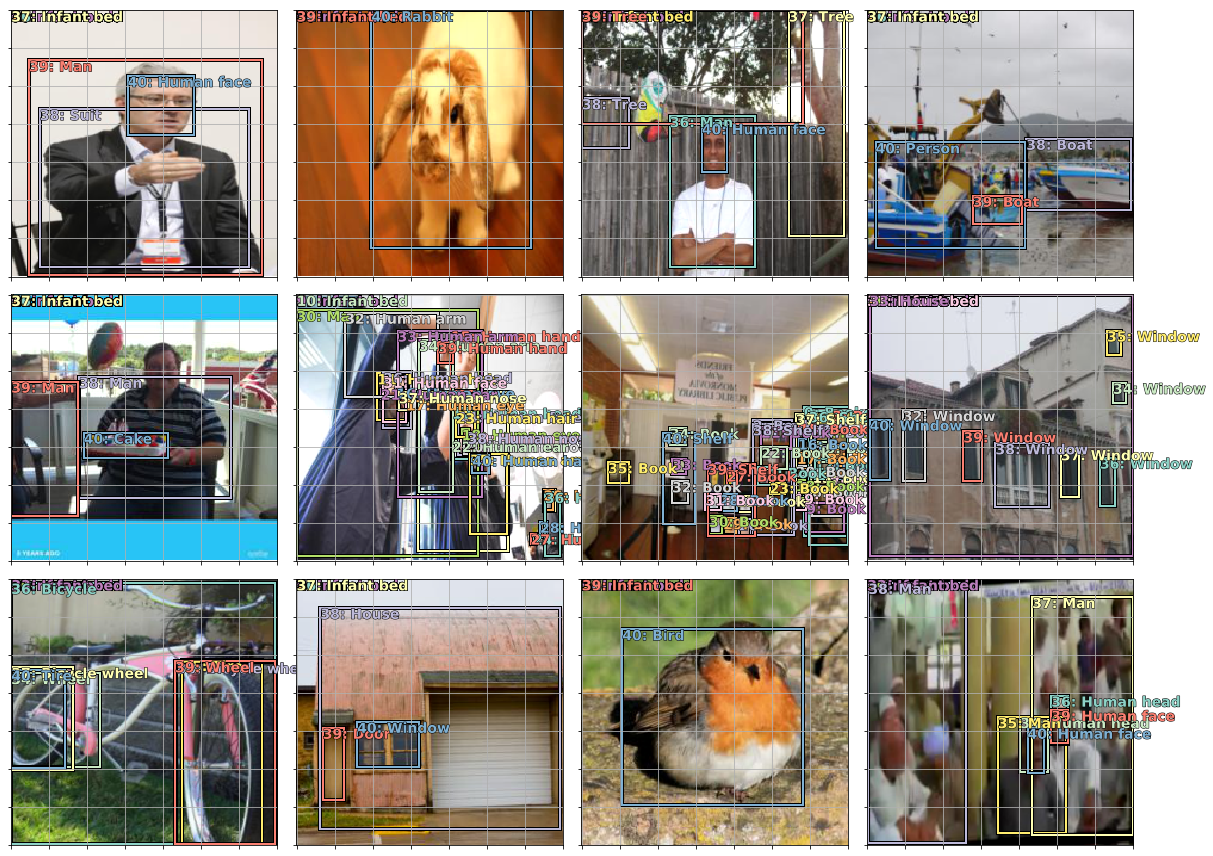

In [58]:
fig, axes = plt.subplots(3, 4, figsize=(16,12))
for i, ax in enumerate(axes.flat):
    show_ground_truth(ax, x[i], y[0][i], y[1][i])
plt.tight_layout()

We can also look at image augmentations. As we expect, the bounding box coordinates follow the translations of the image.

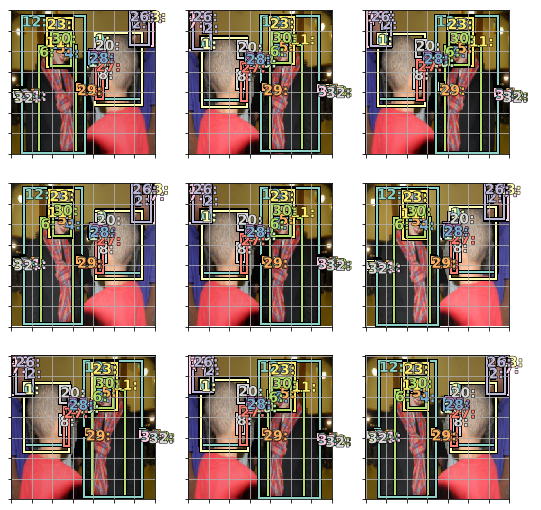

In [59]:
idx=5
fig,axes = plt.subplots(3,3, figsize=(9,9))
for i,ax in enumerate(axes.flat):
    x,y=next(iter(md.aug_dl))
    ima=md.val_ds.ds.denorm(to_np(x))[idx]
    show_ground_truth(ax, ima, y[idx])

# 5. Create Anchor Boxes

Here we define the anchor boxes, their aspects and their zooms.

We are able to use 4x4, 2x2, 1x1 anchor boxes because the output from the resnet base model is 7x7. If different anchor box grids were desired, or the base model produced an output of different size, adjustments would need to be made.

In [60]:
anc_grids = [4, 2, 1]
anc_zooms = [0.7, 1., 1.3]
anc_ratios = [(1.,1.), (1., 0.5), (0.5, 1.)]
anchor_scales = [(anz*i, anz*j) for anz in anc_zooms for (i,j) in anc_ratios]
k = len(anchor_scales)
anc_offsets = [1/(o*2) for o in anc_grids]

In [61]:
k

9

In [62]:
anchor_scales

[(0.7, 0.7),
 (0.7, 0.35),
 (0.35, 0.7),
 (1.0, 1.0),
 (1.0, 0.5),
 (0.5, 1.0),
 (1.3, 1.3),
 (1.3, 0.65),
 (0.65, 1.3)]

In [64]:
def hw2corners(ctr, hw):
    return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

In [65]:
anc_x = np.concatenate([np.repeat(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_y = np.concatenate([np.tile(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)

In [66]:
anc_sizes  =   np.concatenate([np.array([[o/ag,p/ag] for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids])
grid_sizes = V(np.concatenate([np.array([ 1/ag       for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids]), requires_grad=False).unsqueeze(1)

In [67]:
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])

In [68]:
anchors.shape

torch.Size([189, 4])

In [69]:
a = np.reshape((to_np(anchor_cnr) + to_np(torch.randn(*anchor_cnr.size()))*0.01)*224, -1)

# 6. Convolutional Output Functions

Here we define a few functions to create the output we want.

StdConv will be our generic convolutional layer consisting of a convolution of stride 2 followed by relu, batchnorm and dropout.

OutConv uses two separate convolutional output layers to return a tensor for class predictions and a tensor for bounding box predictions for each bounding box represented by the input tensor.

SSD_MultiHead is the actual output function used. It consists of four convolutional layers. The last three convolutional layers feed their output activations into an OutConv layer to produce the final output predictions for all 189 bounding boxes.

In [70]:
class StdConv(nn.Module):
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x):
        return self.drop(self.bn(F.relu(self.conv(x))))

def flatten_conv(x, k):
    bs, nf, gx, gy = x.size()
    x = x.permute(0, 2, 3, 1).contiguous()
    return x.view(bs, -1, nf//k)

In [71]:
class OutConv(nn.Module):
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, (len(id2cat)+1)*k, 3, padding=1)
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1)
        self.oconv1.bias.data.zero_().add_(bias)
    
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k),
               flatten_conv(self.oconv2(x), self.k)]

In [72]:
drop = 0.4

class SSD_MultiHead(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(drop)
        self.sconv0 = StdConv(512, 256, stride=1, drop=drop)
        self.sconv1 = StdConv(256, 256, drop=drop)
        self.sconv2 = StdConv(256, 256, drop=drop)
        self.sconv3 = StdConv(256, 256, drop=drop)
        
        self.out0 = OutConv(k, 256, bias)
        self.out1 = OutConv(k, 256, bias)
        self.out2 = OutConv(k, 256, bias)
        self.out3 = OutConv(k, 256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        x = self.sconv1(x)
        o1c, o1l = self.out1(x)
        x = self.sconv2(x)
        o2c, o2l = self.out2(x)
        x = self.sconv3(x)
        o3c, o3l = self.out3(x)
        return [torch.cat([o1c, o2c, o3c], dim=1),
               torch.cat([o1l, o2l, o3l], dim=1)]

In [73]:
def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b):
    return ((b[:, 2] - b[:, 0]) * (b[:, 3] - b[:,1]))

def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

In [74]:
def get_y(bbox, clas):
    bbox = bbox.view(-1, 4) #/sz
    
    if ((bbox[:,2] - bbox[:,0])>0).nonzero().dim() > 1:
        bb_keep = ((bbox[:,2] - bbox[:,0])>0).nonzero()[:,0]
    else:
        bb_keep = ((bbox[:,3] - bbox[:,1])>0).nonzero()[:,0]
    
    bbox = bbox/sz
    
    return bbox[bb_keep], clas[bb_keep]

def actn_to_bb(actn, anchors):
    actn_bbs = torch.tanh(actn)
    actn_centers = (actn_bbs[:, :2]/2 * grid_sizes) + anchors[:, :2]
    actn_hw = (actn_bbs[:, 2:]/2+1) * anchors[:, 2:]
    return hw2corners(actn_centers, actn_hw)

def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it:
        print(prior_overlap)
        
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx):
        gt_idx[o] = i
        
    return gt_overlap, gt_idx

# 7. Loss Function

Here we define how the loss function will work for analyzing classification and regression predictions.

BCE_Loss calculates binary cross entropy for class predictions.

In [75]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        
    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes+1)
        t = V(t[:,:-1].contiguous())
        x = pred[:,:-1]
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)/self.num_classes
    
    def get_weight(self, x, t):
        return None    

## Full Loss Function

ssd_1_loss calculates the loss for one set of predictions. 

For bounding box data:

   The output activations are converted into bounding box coordinates. Then the jaccard function finds the IOU for each anchor box when compared to the ground truth bounding boxes. This determines which anchor boxes correspond to which bounding boxes for the loss function. For anchor boxes that correspond to a class (are not background), the grouth truth coordinates associated with that anchor box are compared to the predicted coordinates associated with that box. Loss is calculated by mean absolute difference.
    
   Classification loss is calculated using binary cross entropy.

In [156]:
def ssd_1_loss(b_c, b_bb, bbox, clas, print_it=False):
    bbox, clas = get_y(bbox, clas)
    a_ic = actn_to_bb(b_bb, anchors)
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    gt_overlap, gt_idx = map_to_ground_truth(overlaps, print_it)
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    gt_clas[1-pos] = len(id2cat)
    gt_bbox = bbox[gt_idx]
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    clas_loss = loss_f(b_c, gt_clas)
    return loc_loss, clas_loss


def ssd_loss(pred, targ, print_it=False):
    lcs, lls = 0., 0.
    for b_c, b_bb, bbox, clas in zip(*pred, *targ):
        loc_loss, clas_loss = ssd_1_loss(b_c, b_bb, bbox, clas, print_it)
        lls += loc_loss
        lcs += clas_loss
        
    if print_it:
        print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
    return lls+lcs

In [77]:
def torch_gt(ax, ima, bbox, clas, prs=None, thresh=0.4):
    return show_ground_truth(ax, ima, to_np((bbox*224).long()),
                to_np(clas), to_np(prs) if prs is not None else None, thresh)

# 8. Focal Loss

Here we implement Focal Loss, a variation of binary cross entropy introduced in [this paper](https://arxiv.org/pdf/1708.02002.pdf). It was found that the cross entropy function gave too strong a penalty for correct classifications that did not have sufficiently high probability. The result was that models would fail to classify objects in an image, simply classifying everything as background, because there was too strong a penalty with being correct but not correct enough. Focal loss weights the cross entropy loss by:

$$-\alpha*(1-p_{t})^\gamma * log(p_{t})$$

Where

$$
p_{t} = \left\{
        \begin{array}{ll}
            p & \quad x = 0 \\
            1-p & \quad otherwise
        \end{array}
    \right.
$$

The effect of the focal loss coefficient is to dampen the loss contribution from higher probability classifications and focus the model on poorly classified examples.

In [78]:
class FocalLoss(BCE_Loss):
    def get_weight(self, x, t):
        alpha, gamma = 0.25, 1
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return w * (1-pt).pow(gamma)

# 9. Model Training

Here we actually create the model. We add the output function we created earlier to a resnet34 model.

In [90]:
head_reg4 = SSD_MultiHead(k, -4.)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head = head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

In [91]:
loss_f = FocalLoss(len(id2cat))

Lets check that the loss function is working properly

In [92]:
x, y = next(iter(md.val_dl))
x, y = V(x), V(y)

In [93]:
batch = learn.model(x)

In [94]:
batch[1][0].shape

torch.Size([189, 4])

In [95]:
ssd_loss(batch, y, True)

tensor([ 0.7006,  0.6867,  0.7175], device='cuda:1')
tensor([ 0.1933,  0.5778,  0.4293], device='cuda:1')
tensor([ 0.2543,  0.2843,  0.1333,  0.6239,  0.4748], device='cuda:1')
tensor([ 0.3567,  0.4845,  0.2807,  0.4095,  0.2354,  0.1829,  0.1087,
         0.0302,  0.0153,  0.0345,  0.0281,  0.0390], device='cuda:1')
tensor([ 0.2247,  0.4974,  0.1648], device='cuda:1')
tensor([ 0.5375,  0.4942,  0.1991,  0.0442,  0.0457,  0.0627,  0.4476,
         0.0750,  0.1332,  0.0871,  0.0504,  0.0527,  0.4479,  0.0918,
         0.0885,  0.0089,  0.6065,  0.0351,  0.0191,  0.5797,  0.1688,
         0.1471,  0.0175,  0.4389,  0.0580,  0.0290,  0.5853,  0.1907,
         0.1532,  0.0159,  0.3251,  0.0421,  0.0172], device='cuda:1')
tensor([ 0.4635,  0.5770,  0.3174,  0.6293,  0.7074], device='cuda:1')
tensor([ 0.6342], device='cuda:1')
tensor([ 0.7813,  0.2933,  0.0932,  0.2132,  0.1507,  0.1214], device='cuda:1')
tensor([ 0.7256,  0.3635,  0.8264,  0.6900,  0.5300], device='cuda:1')
tensor([ 0.7401,

C:\Users\GATEWAY\Anaconda2\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:24: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
C:\Users\GATEWAY\Anaconda2\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:24: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


loc: 6.900505065917969, clas: 5.229013442993164


tensor(12.1295, device='cuda:1')

Here is the model. You can see the SSD_MultiHead starting after the final resnet block.

In [85]:
learn.model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, ker

We set a learning rate and away we go.

In [96]:
learn.crit = ssd_loss
lr = 1e-2
lrs = np.array([lr/100, lr/10, lr])

 72%|████████████████████████████████████████████████▏                  | 1731/2404 [26:58<10:29,  1.07it/s, loss=22.7]

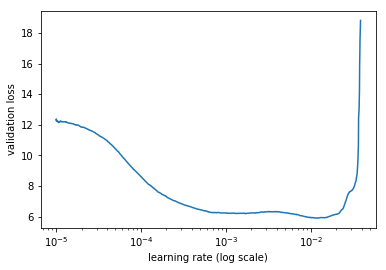

In [87]:
learn.lr_find(lrs/1000, 1.)
learn.sched.plot(1)

In [97]:
learn.fit(lr/10, 1, cycle_len=10, use_clr=(20,10), cycle_save_name='e1', best_save_name='b1')

epoch      trn_loss   val_loss                                                                                         
    0      5.404944   5.23295   
    1      5.056907   4.882013                                                                                         
    2      4.941535   4.754715                                                                                         
    3      4.88115    4.686465                                                                                         
    4      4.816018   4.620412                                                                                         
    5      4.761105   4.579745                                                                                         
    6      4.685093   4.540093                                                                                         
    7      4.628169   4.504968                                                                                         
    8  

[4.4700499730003544]

epoch      trn_loss   val_loss                                                                                         
    0      6.85154    8.419241  


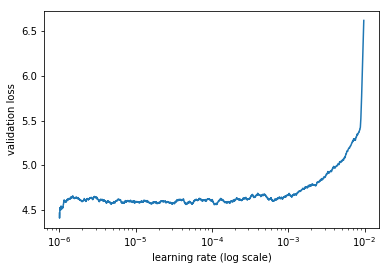

In [99]:
learn.lr_find(lrs/10000, 1./100)
learn.sched.plot(1)

In [113]:
learn.freeze_to(-2)
learn.fit(lrs/20, 1, cycle_len=10, use_clr=(20,10), cycle_save_name='e2', best_save_name='b2')

epoch      trn_loss   val_loss                                                                                         
    0      4.425911   4.297062  
    1      4.353724   4.195936                                                                                         
    2      4.283928   4.133377                                                                                         
    3      4.169068   4.086793                                                                                         
    4      4.05651    4.055966                                                                                         
    5      4.000579   4.022913                                                                                         
    6      3.933082   4.005983                                                                                         
    7      3.864775   3.998325                                                                                         
    8  

[3.984581578602347]

In [114]:
learn.fit(lrs/50, 1, cycle_len=6, use_clr=(25,6), cycle_save_name='e3', best_save_name='b3')

epoch      trn_loss   val_loss                                                                                         
    0      3.811587   4.001393  
    1      3.801025   3.995177                                                                                         
    2      3.780734   3.989004                                                                                         
    3      3.734902   3.989374                                                                                         
    4      3.67797    3.983047                                                                                         
    5      3.663011   3.97973                                                                                          


[3.9797297626501313]

That looks like a good stopping point.

# 10. Viewing Predictions

Here is what our model predicts with a loose threshold

In [100]:
def plot_results(thresh):
    x,y = next(iter(md.val_dl))
    y = V(y)
    batch = learn.model(V(x))
    b_clas,b_bb = batch

    x = to_np(x)
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    for idx,ax in enumerate(axes.flat):
        ima=md.val_ds.ds.denorm(x)[idx]
        bbox,clas = get_y(y[0][idx], y[1][idx])
        a_ic = actn_to_bb(b_bb[idx], anchors)
        clas_pr, clas_ids = b_clas[idx].max(1)
        clas_pr = clas_pr.sigmoid()
        torch_gt(ax, ima, a_ic, clas_ids, clas_pr, clas_pr.max().data[0]*thresh)
    plt.tight_layout()

C:\Users\GATEWAY\Anaconda2\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:15: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  from ipykernel import kernelapp as app
C:\Users\GATEWAY\Anaconda2\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:15: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  from ipykernel import kernelapp as app
C:\Users\GATEWAY\Anaconda2\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:15: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  from ipykernel import kernelapp as app
C:\Users\GATEWAY\Anaconda2\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:15: UserWarning: invalid index of a 0-dim tensor. This will be an error in P

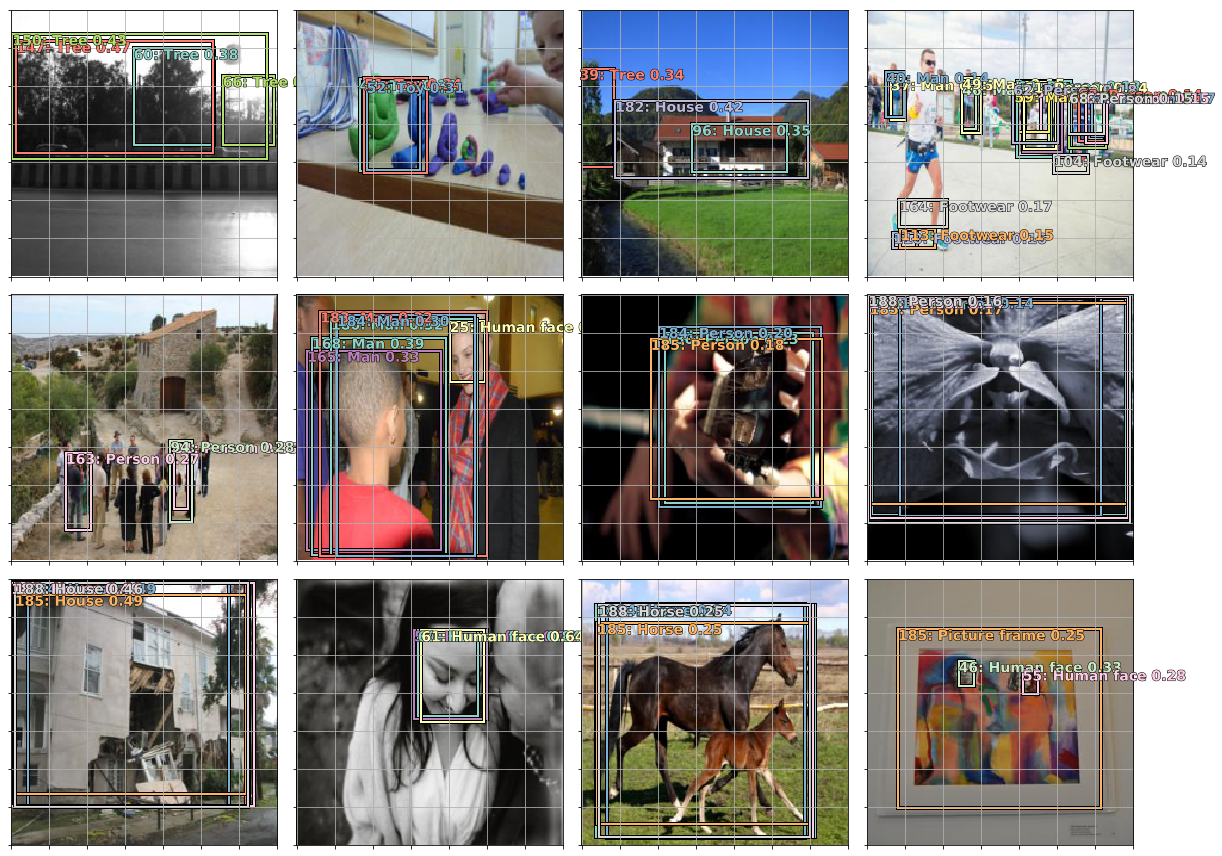

In [115]:
plot_results(0.75)

We can see a ton of repeated bounding boxes classifying the same object. We can clean these up with non-maximum suppression.

# 11. Non-Maximum Suppression

In [105]:
def nms(boxes, scores, overlap=0.5, top_k=100):
    keep = scores.new(scores.size(0)).zero_().long()
    if boxes.numel() == 0: return keep
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)
    v, idx = scores.sort(0)  # sort in ascending order
    idx = idx[-top_k:]  # indices of the top-k largest vals
    xx1 = boxes.new()
    yy1 = boxes.new()
    xx2 = boxes.new()
    yy2 = boxes.new()
    w = boxes.new()
    h = boxes.new()

    count = 0
    while idx.numel() > 0:
        i = idx[-1]  # index of current largest val
        keep[count] = i
        count += 1
        if idx.size(0) == 1: break
        idx = idx[:-1]  # remove kept element from view
        # load bboxes of next highest vals
        torch.index_select(x1, 0, idx, out=xx1)
        torch.index_select(y1, 0, idx, out=yy1)
        torch.index_select(x2, 0, idx, out=xx2)
        torch.index_select(y2, 0, idx, out=yy2)
        # store element-wise max with next highest score
        xx1 = torch.clamp(xx1, min=x1[i])
        yy1 = torch.clamp(yy1, min=y1[i])
        xx2 = torch.clamp(xx2, max=x2[i])
        yy2 = torch.clamp(yy2, max=y2[i])
        w.resize_as_(xx2)
        h.resize_as_(yy2)
        w = xx2 - xx1
        h = yy2 - yy1
        # check sizes of xx1 and xx2.. after each iteration
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w*h
        # IoU = i / (area(a) + area(b) - i)
        rem_areas = torch.index_select(area, 0, idx)  # load remaining areas)
        union = (rem_areas - inter) + area[i]
        IoU = inter/union  # store result in iou
        # keep only elements with an IoU <= overlap
        idx = idx[IoU.le(overlap)]
    return keep, count

In [116]:
x,y = next(iter(md.val_dl))
y = V(y)
batch = learn.model(V(x))
b_clas,b_bb = batch
x = to_np(x)

In [107]:
def show_nmf(idx, IOU, conf):
    ima=md.val_ds.ds.denorm(x)[idx]
    bbox,clas = get_y(y[0][idx], y[1][idx])
    a_ic = actn_to_bb(b_bb[idx], anchors)
    clas_pr, clas_ids = b_clas[idx].max(1)
    clas_pr = clas_pr.sigmoid()

    conf_scores = b_clas[idx].sigmoid().t().data

    out1,out2,cc = [],[],[]
    for cl in range(0, len(conf_scores)-1):
        c_mask = conf_scores[cl] > conf
        if c_mask.sum() == 0: continue
        scores = conf_scores[cl][c_mask]
        l_mask = c_mask.unsqueeze(1).expand_as(a_ic)
        boxes = a_ic[l_mask].view(-1, 4)
        ids, count = nms(boxes.data, scores, IOU, 50)
        ids = ids[:count]
        out1.append(scores[ids])
        out2.append(boxes.data[ids])
        cc.append([cl]*count)
    cc = T(np.concatenate(cc))
    out1 = torch.cat(out1)
    out2 = torch.cat(out2)

    fig, ax = plt.subplots(figsize=(6,6))
    torch_gt(ax, ima, out2, cc, out1, 0.1)

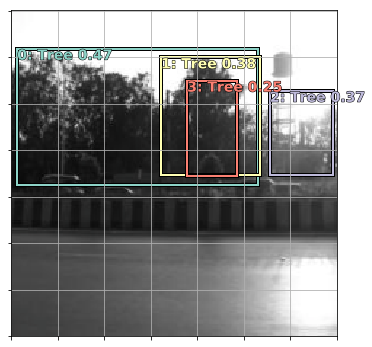

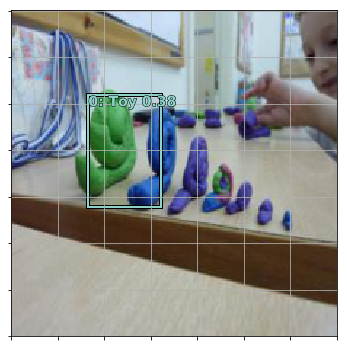

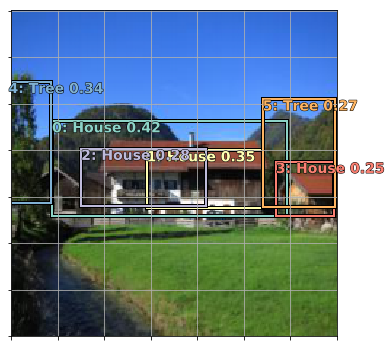

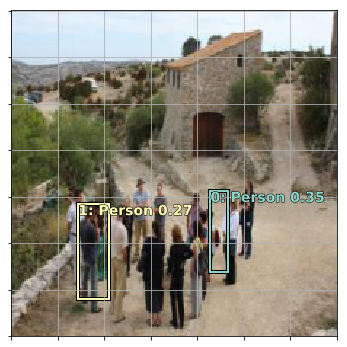

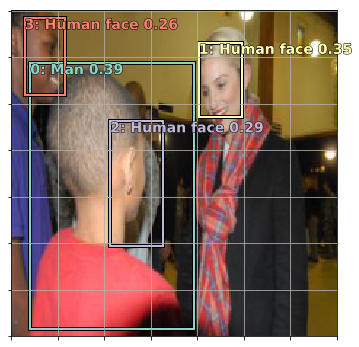

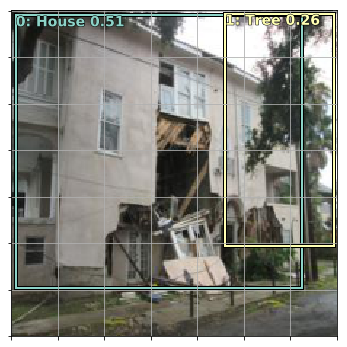

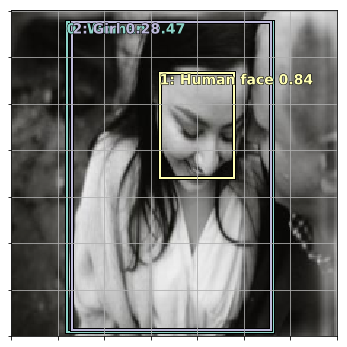

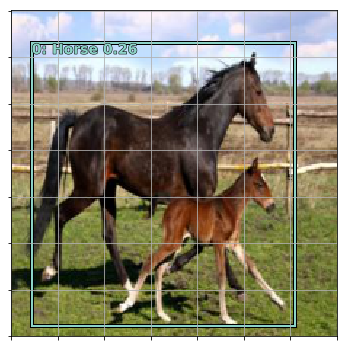

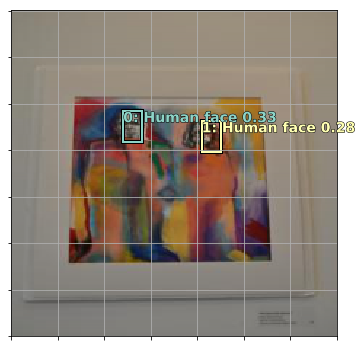

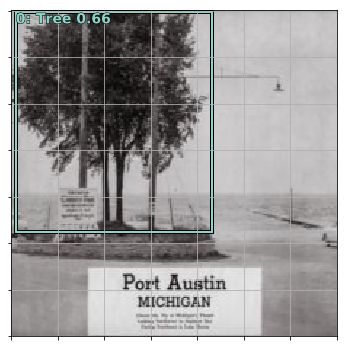

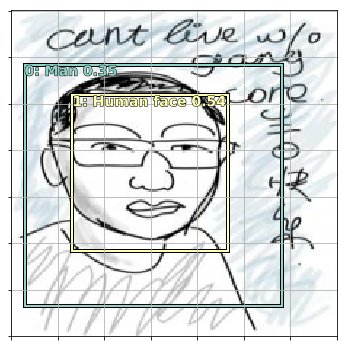

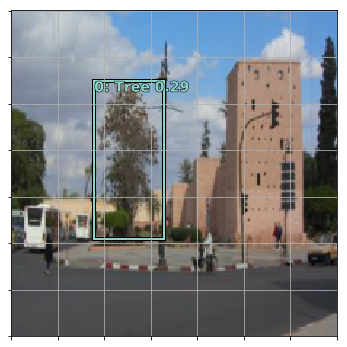

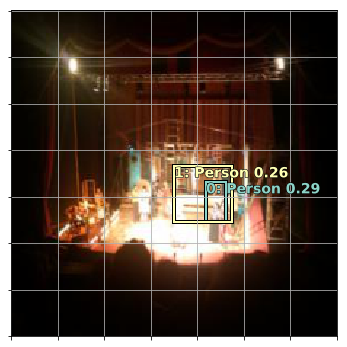

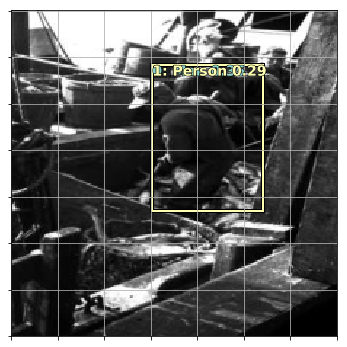

In [121]:
for i in range(20):
    try:
        show_nmf(i, 0.4, 0.25)
        
    except:
        pass

This looks clearer. The high confidence predictions seem pretty good. Unfortunately there aren't many high confidence predictions per image. Looking at lower confidence predictions shows areas where the model struggles.

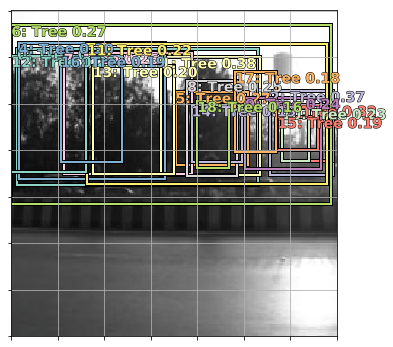

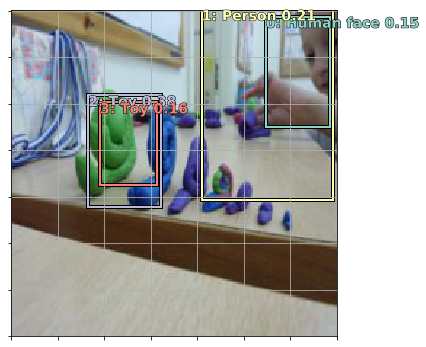

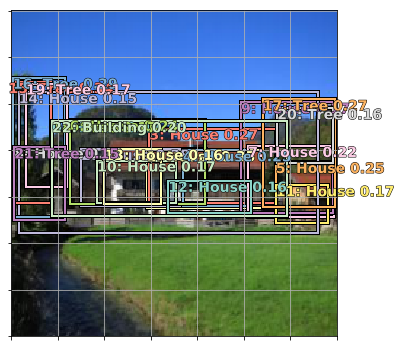

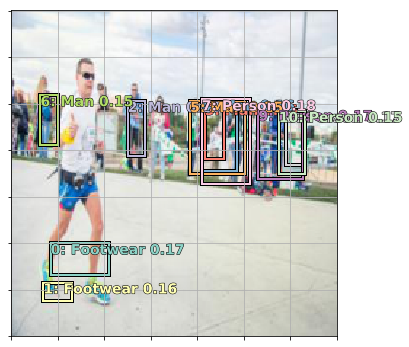

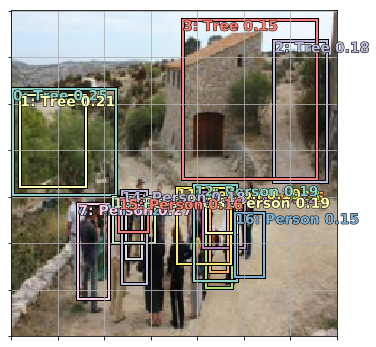

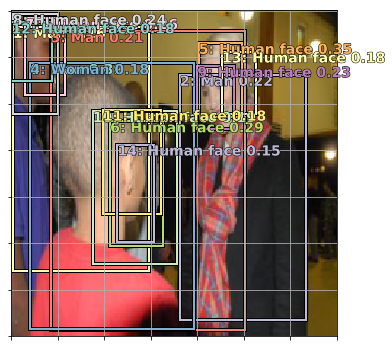

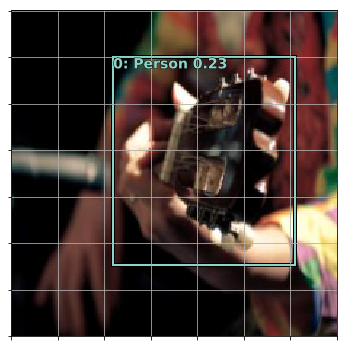

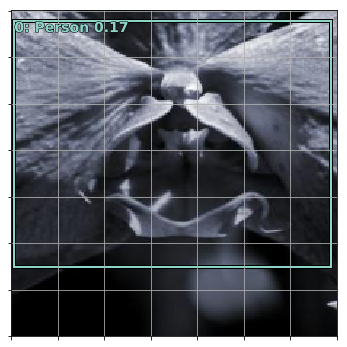

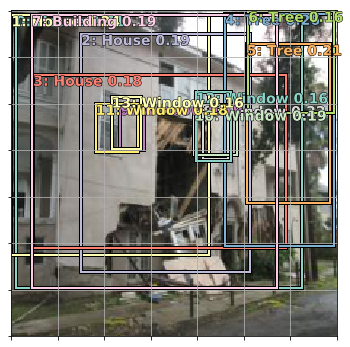

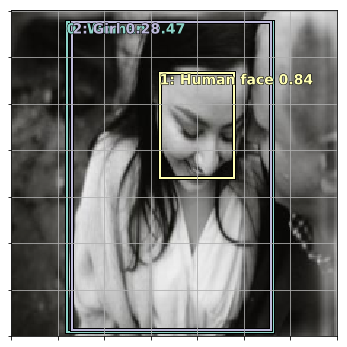

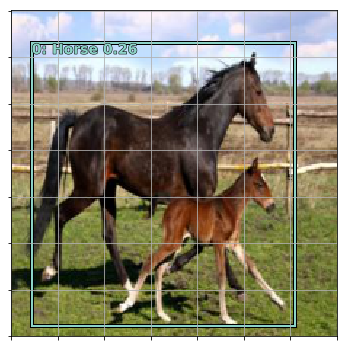

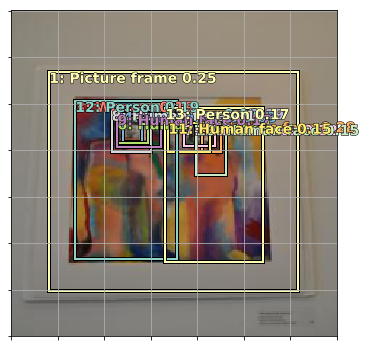

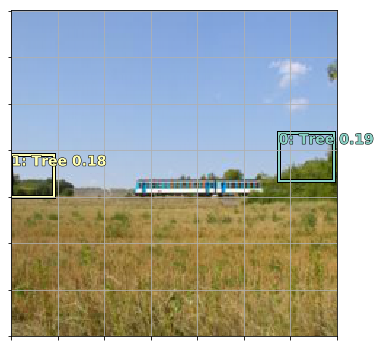

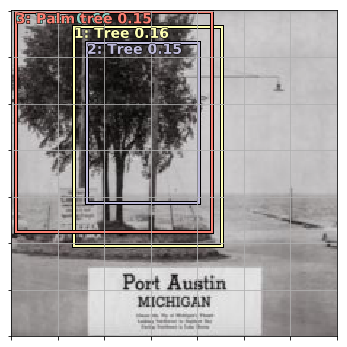

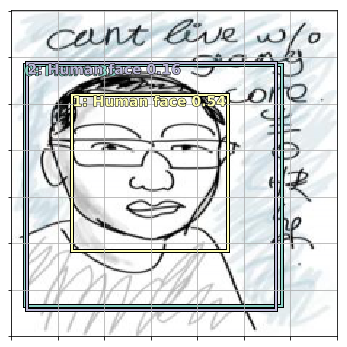

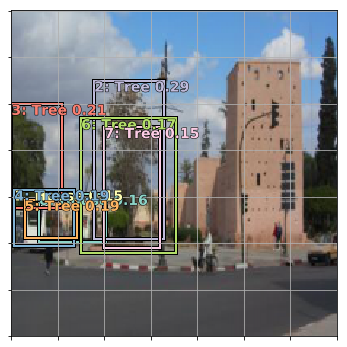

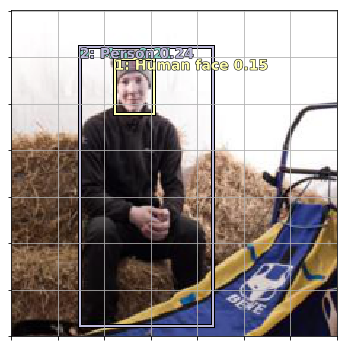

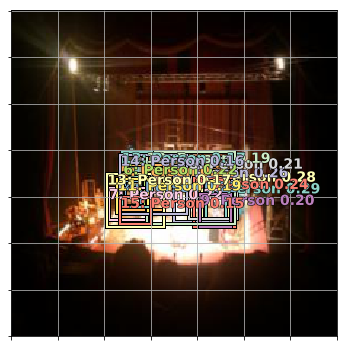

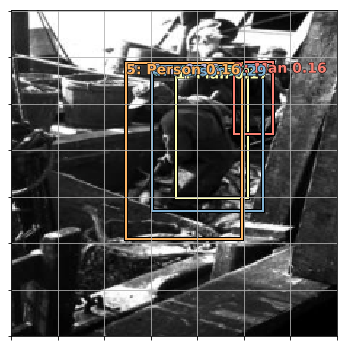

In [122]:
for i in range(20):
    try:
        show_nmf(i, 0.6, 0.15)
        
    except:
        pass

At lower confidence levels we see the model 

This looks cleaner. The model seems generally on point for most images, but seems to struggle with fine detail. Many of the boxes are generally accurate but poorly fitted for the object they have found. Maybe things would look better after training on the full 500 GB of images.

# 12. Afterthoughts

There was a lot of frustration and reward with this project. Surprisingly one of the hardest parts was figuring out how to get the bounding box coordinates in the right format - efficiently loading and getting the sizes of every image, making sure coordinates were scaled the same as images, etc. Lots of having to backtrack because of little details I wasn't aware of.

After all that it's great to see the final model running.

In [157]:
#Dump the dictionaries real quick so I never have to run the bounding box scaling again

In [124]:
pickle.dump(cats, open(PATH/'tmp_all'/'224'/'cats.pkl', 'wb'))

In [136]:
trn_anno_dict = {k: trn_anno[k] for k in trn_anno.keys()}
pickle.dump(trn_anno_dict, open(PATH/'tmp_all'/'224'/'trn_anno.pkl', 'wb'))

In [141]:
pickle.dump(trn_ids, open(PATH/'tmp_all'/'224'/'trn_ids.pkl', 'wb'))

In [148]:
pickle.dump(trn_fns, open(PATH/'tmp_all'/'224'/'trn_fns.pkl', 'wb'))

In [151]:
pickle.dump(code2label, open(PATH/'tmp_all'/'224'/'code2label.pkl', 'wb'))